In [14]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
import ccdproc as ccdp
from ccdproc import subtract_bias

In [15]:
DEBUG = True

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [16]:
files = ccdp.ImageFileCollection('../data/darks_d')
files.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2', 'naxis3', 'gain']

file,imagetyp,exptime,naxis1,naxis2,naxis3,gain
str9,str10,float64,int64,int64,int64,int64
d_r01.fit,Dark Frame,180.0,3840,2160,3,252
d_r02.fit,Dark Frame,180.0,3840,2160,3,252
d_r03.fit,Dark Frame,180.0,3840,2160,3,252
d_r04.fit,Dark Frame,180.0,3840,2160,3,252
d_r05.fit,Dark Frame,180.0,3840,2160,3,252
d_r06.fit,Dark Frame,180.0,3840,2160,3,252
d_r07.fit,Dark Frame,180.0,3840,2160,3,252


In [17]:
#копируем файлы из папки data в папку reduced
calibrated_data = Path('../reduced_d')
calibrated_data.mkdir(exist_ok=True)

darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)

import shutil

for dark in darks:
    shutil.copy(dark, calibrated_data)

In [46]:
calibrated_path = Path('../reduced_d')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_darks = reduced_images.files_filtered(imagetyp='Dark Frame', include_path=True)

dark_file = calibrated_darks[0]
dark_ccd = CCDData.read(dark_file, unit='adu') 

dark_data = dark_ccd.data[1] #берём зеленый канал

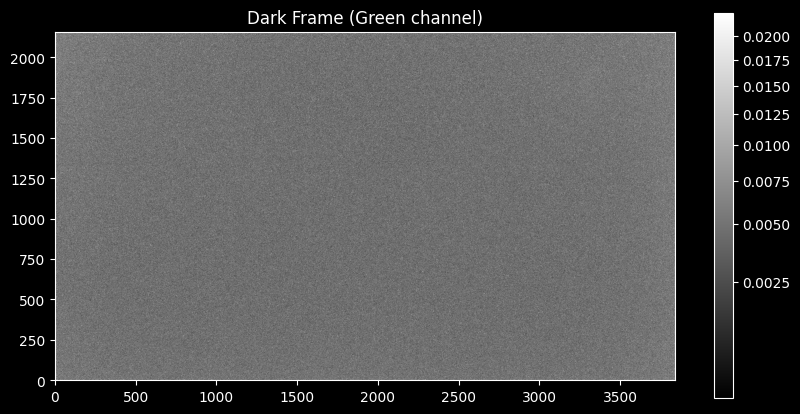

In [47]:
norm = simple_norm(dark_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(dark_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Dark Frame (Green channel)')
plt.show()

Mean: 0.005271948408335447
STD: 0.0042310417629778385
MAD STD: 0.0018941995222121477


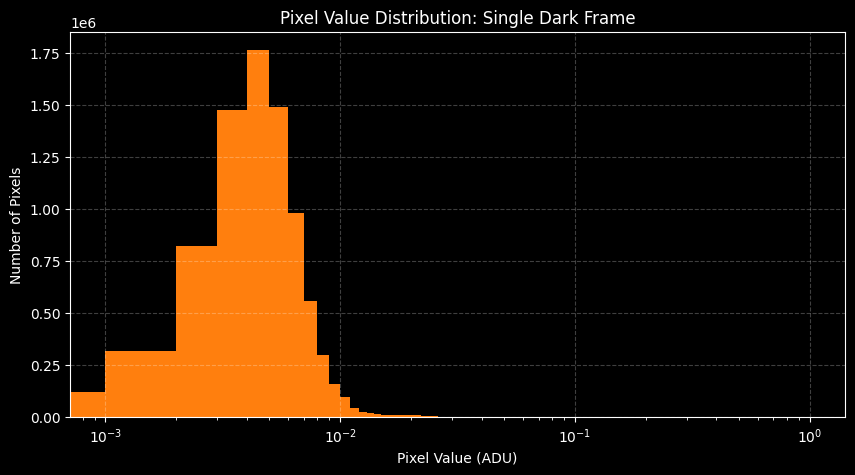

In [48]:
dark_hist = dark_data.flatten()

print(f'Mean: {np.mean(dark_data)}')
print(f'STD: {np.std(dark_data)}')
print(f'MAD STD: {mad_std(dark_data)}')

plt.figure(figsize=(10, 5))
plt.hist(dark_hist, bins=1000, color='tab:orange')
plt.title('Pixel Value Distribution: Single Dark Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.semilogx()
plt.show()

In [58]:
green_darks = []
for file in calibrated_darks:
    ccd = CCDData.read(file, unit='adu')
    mono = ccd.data[1]  # берём зелёный канал
    ccd_mono = CCDData(mono, unit='adu', meta=ccd.meta)
    green_darks.append(ccd_mono)

combined_dark_avg_d = ccdp.combine(green_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=360e6,
                                 unit='adu')

combined_dark_avg_d.meta['combined'] = True
combined_dark_avg_d.write(calibrated_path / 'combined_dark_avg_d.fit', overwrite=True)


INFO:astropy:splitting each image into 8 chunks to limit memory usage to 360000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 360000000.0 bytes. [ccdproc.combiner]


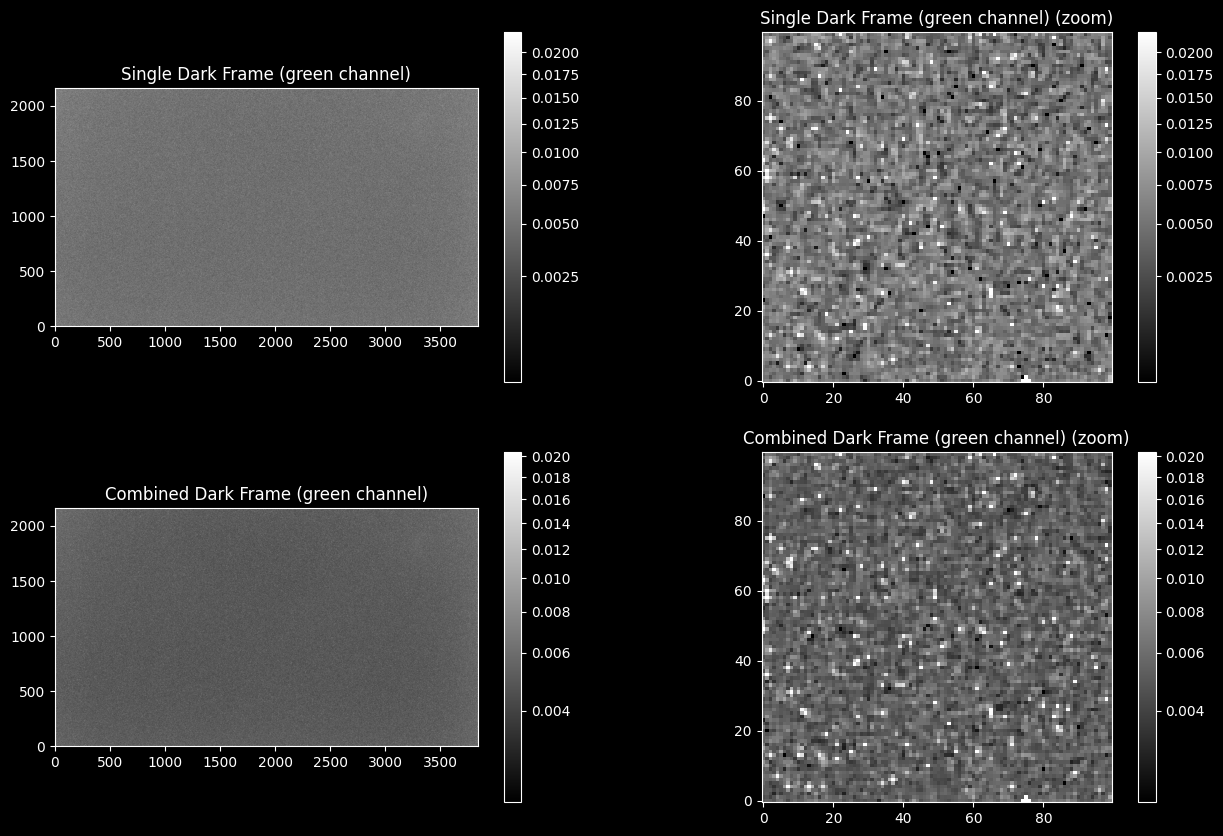

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(dark_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Dark Frame (green channel)')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(dark_data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Dark Frame (green channel) (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_dark_avg_d.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_dark_avg_d.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Dark Frame (green channel)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_dark_avg_d.data, stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_dark_avg_d.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Dark Frame (green channel) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()


          | Single Dark Frame(g)| Combined Dark Frame(g)
--------------------------------------------------------
Mean      |       0.00527       |        0.00541        
STD       |       0.00423       |        0.00355        
MAD STD   |       0.00189       |        0.00103        


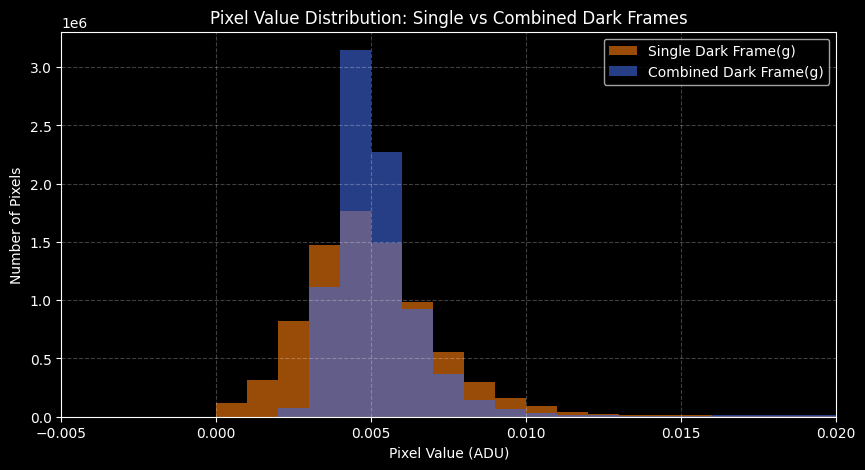

In [75]:
combined_dark_avg_d_hist = combined_dark_avg_d.data.flatten()

print(f'{"":<10}| {"Single Dark Frame(g)":^20}| {"Combined Dark Frame(g)":^22}')
print('-' * 56)
print(f'{"Mean":<10}| {np.mean(dark_data):^20.5f}| {np.mean(combined_dark_avg_d.data):^22.5f}')
print(f'{"STD":<10}| {np.std(dark_data):^20.5f}| {np.std(combined_dark_avg_d.data):^22.5f}')
print(f'{"MAD STD":<10}| {mad_std(dark_data):^20.5f}| {mad_std(combined_dark_avg_d.data):^22.5f}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(dark_hist, bins=1000, color='tab:orange', alpha=0.6, label='Single Dark Frame(g)')
plt.hist(combined_dark_avg_d_hist, bins=1000, color='royalblue', alpha=0.6, label='Combined Dark Frame(g)')
plt.title('Pixel Value Distribution: Single vs Combined Dark Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.xlim(-0.005,0.02)
plt.show()